# Persistent Homology: some real examples

Let us first load again our functions, and then we look at some real examples: one from chemistry (fullerenes), and one from biology ($\alpha$-helix in a protein).

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from operator import itemgetter
import profile
import scipy.sparse as sps
import time

def Lower_Nbrs(V,E,u):
    #find all the neighbors v of vertex u in the neighborhood graph G=(V,E) 
    #that precede it (in whichever ordering the vertices are)
    return{v for v in V if u > v and ([u,v] in E or [v,u] in E)}

def VRcomplex(D,k,eps):
    #inputs: the set D of data points,and k is the max dimension desired for the simplices
    #(k=0 for vertices, k=1 for edges, k=2 for triangles, k=3 for tetrahedra...)
    #eps is the parameter for the size of the neighborhood
    #output: the corresponding VRcomplex and weights

    #stores weights
    weights = []
    
    #this creates the neighborhood graph and add its vertices and edges to the complex
    #add vertices to the complex
    nb_nodes = len(D)
    VRcomplex = [[j] for j in range(0,nb_nodes)]
    #add edges
    nb_edges = 0
    for i in range(0,nb_nodes):
        for j in range(i+1,nb_nodes):
            #this is O(nb_nodes^2)
            if np.linalg.norm(D[i]-D[j]) < eps:
                VRcomplex.append([i,j])
                weights.append(np.linalg.norm(D[i]-D[j]))
                nb_edges = nb_edges + 1
        
    for i in range(1,k):
        for simplex in [v for v in VRcomplex if len(v)==i+1]:
            N = set.intersection(*[Lower_Nbrs(range(0,nb_nodes),VRcomplex[nb_nodes:nb_nodes+nb_edges],u) for u in simplex])
            for n in N:
                VRcomplex.append(sorted(list(set.union({n},simplex)),key=int))
    
    return(VRcomplex,weights)

def PlotVRcomplex(D,complex):
    #take as input the data points and the output of VRcomplex and plots it
    
    nb_nodes = len(D)
    nb_edges = len([simplex for simplex in complex if len(simplex)==2])
    dim = len(D[0])
    
    if dim == 2:
        #draw and annotate nodes
        for i in range(0,nb_nodes):
            plt.plot(D[i,0],D[i,1],'ob')
            plt.annotate(i,(D[i,0],D[i,1]+0.05))
        
        #draw edges    
        for j in range(nb_nodes,nb_nodes+nb_edges):
            plt.plot([D[complex[j][0],0],D[complex[j][1],0]],[D[complex[j][0],1],D[complex[j][1],1]],'b')
        
        #draw surfaces
        idx = nb_nodes+nb_edges
        while idx<len(complex) and len(complex[idx])==3:
            #extract triangles, and sort them according to their x components
            trg = sorted(D[complex[idx]],key=itemgetter(0))
            a = (trg[0][1]-trg[2][1])/(trg[0][0]-trg[2][0])
            b = trg[0][1]-a*trg[0][0]
            plt.fill_between([trg[j][0] for j in range(3)],[trg[j][1] for j in range(3)],[trg[0][1],a*trg[1][0]+b,trg[2][1]],color='blue',alpha='0.5')
            idx = idx+1
        plt.axis([-1.5,1.5,-1.5,1.5])
        plt.gca().set_aspect('equal',adjustable='box')
    
    if dim == 3:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.set_aspect('equal')
        #draw and annotate nodes
        for i in range(0,nb_nodes):
            ax.scatter3D(D[i,0],D[i,1],D[i,2])
            label = '%d' % i
            ax.text(D[i,0],D[i,1]+0.05,D[i,2],label)
            
        #draw edges    
        for j in range(nb_nodes,nb_nodes+nb_edges):
            ax.plot3D([D[complex[j][0],0],D[complex[j][1],0]],[D[complex[j][0],1],D[complex[j][1],1]],[D[complex[j][0],2],D[complex[j][1],2]],'b')
        
        #draw surfaces
        idx = nb_nodes+nb_edges
        trg = []
        while idx<len(complex) and len(complex[idx])==3:
            #extract triangles
            trg.append(D[complex[idx]])
            idx = idx+1
        trgs = Poly3DCollection(trg)
        ax.add_collection3d(trgs)    
            
def BoundMatrix(complex,n):
    #take as input a complex given as a list of its simplices, and the dimension n such that we compute the (n-1)-boundary
    #which is given as a matrix with columns indexed by n-simplices
    
    nsimplex = [simplex for simplex in complex if len(simplex)==n]
    nbcols = len(nsimplex)
    n_1simplex = [simplex for simplex in complex if len(simplex)==n-1]
    nbrows = len(n_1simplex)
    
    B = np.zeros((nbrows,nbcols), dtype = np.uint8)
    for i in range(0,nbcols):
        simplex = nsimplex[i]
        for j in range(0,len(simplex)):
            n_1newsimplex = [x for x in simplex if x != simplex[j]]
            #over Z, we would use (-1)**j, but over F2 is good enough for us
            B[n_1simplex.index(n_1newsimplex),i] = 1 
    return B
            
def BarCode(C,k):
    #input: a complex C (C[0]) with its weights (C[1]) and the highest simplex dimension k
    #output: the intervals defining the bar codes, the transformation matrix, and the weights of the simplices
    
    complex = C[0]
    lenC0 = len(C[0])
    nb_nodes = len([simplex for simplex in complex if len(simplex)==1])
    edges = [simplex for simplex in complex if len(simplex)==2]
    n = nb_nodes*(nb_nodes-1)/2
    weights = np.zeros(lenC0)
    
    #computes the weight of every simplex in the complex C[0]
    cnt_simplex = 0
    for simplex in complex:
        maxweight = 0
        for i in range(0,len(simplex)):
            for j in range(i+1,len(simplex)):
                #recovers the index of the edge and thus the one of its weight
                idx = edges.index([simplex[i],simplex[j]])
                if C[1][idx] > maxweight:
                    maxweight = C[1][idx]
        weights[cnt_simplex] = maxweight
        cnt_simplex = cnt_simplex + 1
    
    complex_sorted = []
    nb_simplex = np.zeros(k+1,dtype=np.int32)
    Btot_reduced = np.zeros((lenC0,lenC0),dtype=np.int8)
    #Btot_reduced = sps.lil_matrix((lenC0,lenC0))
    Btrans = np.identity(lenC0,dtype=np.int8)
     
    #works on simplices per dimension
    for lgth in range(1,k+1):
        nb_simplex[lgth] = len([simplex for simplex in complex if len(simplex)==lgth])
        #lower and upper range that determine the positions of the k-simplices
        lr = sum(nb_simplex[0:lgth])
        ur = sum(nb_simplex[0:lgth+1])
        #total order on the simplices according to the weight function
        complex_sorted.extend([x for (y,x) in sorted(zip(weights[lr:ur],complex[lr:ur]))])    
        weights[lr:ur] = sorted(weights[lr:ur])
       
        if lgth > 1: 
            Btot_reduced[sum(nb_simplex[0:lgth-1]):lr,lr:ur],Btrans[lr:ur,lr:ur] = Reduce(BoundMatrix(complex_sorted[sum(nb_simplex[0:lgth-1]):ur],lgth))   
               
    intervals = []  
    for i in range(0,lenC0):
        if len(Btot_reduced[:,i].nonzero()[0]) == 0:
            intervals.append([i])
        else:
            lw_idx = max(Btot_reduced[:,i].nonzero()[0])
            if [lw_idx] in intervals:
                intervals[intervals.index([lw_idx])].append(i)
        
    return(intervals,Btrans,weights,complex_sorted)    

def PlotBarCode(BC,complex,weights,M,k,eps):
    #take as input a barcode BC,the complex,its weights, its transformation matrix M
    
    nb = [0]
    inter = []
    #plots ticks 
    ytickpos = []
    yticklabel = []
    cnt_tick = 0
    
    #find indices of "born" features
    idx = set(np.where(~(M-np.identity(len(M),dtype=np.int8)).any(axis=1))[0])

    #add eps to the weights
    weights = np.hstack([weights,eps])
    for i in range(1,k+1):
        nb.append(len([simplex for simplex in complex[0] if len(simplex)==i]))
        inter.append(idx.intersection(range(sum(nb[0:i]),sum(nb[0:i+1]))))
    
    cnt_bar = 0
    curr_lgt = 1
    next_lgt = 0
    #plots bar codes
    for i in range(0,len(BC)):
        if len(BC[i])==1:
            #add an explicit end of interval whose weight will be eps
            BC[i].append(len(complex[0]))
        next_lgt = [j for j in range(0,k-1) if BC[i][0] in inter[j]]
        #if len(next_lgt)=0 then this simplex is too high-dim
        if len(next_lgt)>0 and abs(weights[BC[i][0]]-weights[BC[i][1]]) > 0.01 and curr_lgt < k-1:
            #plots only bars which are long enough
            if next_lgt[0] == curr_lgt:
                #counting bars that are drawn
                cnt_bar = cnt_bar + 1
            else:
                curr_lgt = next_lgt[0]
                #plot ticks
                plt.plot([0,eps],[cnt_bar+1,cnt_bar+1],'k--')
                ytickpos.append(cnt_bar+1)
                yticklabel.append(cnt_tick)
                cnt_tick = cnt_tick + 1    
                cnt_bar = cnt_bar + 2
            plt.plot([weights[BC[i][0]],weights[BC[i][1]]],[cnt_bar,cnt_bar])
            
    plt.axis([0,eps,-0.5,cnt_bar+1])
    plt.yticks(ytickpos,yticklabel)
    plt.gca().xaxis.grid(True)

In [10]:
%load_ext Cython

In [11]:
%%cython

import numpy as np
cimport numpy as np
import cython 

def Low(np.ndarray[np.uint8_t, ndim = 1] col, int lgth):
    #take as input a matrix and a column
    #output the non-zero coefficient with the highest index (which is "the lowest" in that it's at the bottom)
    cdef int j
  
    for j in range((lgth-1),-1,-1):
        if col[j]==1:
            return j
    #if the column is the whole zero column, return -1    
    return -1    

def Reduce(np.ndarray[np.uint8_t, ndim =2] M):
    #take as input a matrix with coefficients in 0,1
    #output a reduced form with coefficients 0,1 such that low is injective
    cdef int nbrows,nbcols,i,j,rpt,ent
     
    nbrows = M.shape[0]
    nbcols = M.shape[1]
    
    transM = np.identity(nbcols,dtype=np.int8)
    
    #scan through columns
    for j in range(0,nbcols):
        #scan through previous columns
        rpt = 1
        while rpt == 1:
            ent = 0
            for i in range(0,j):
                if Low(M[:,i],nbrows)== Low(M[:,j],nbrows)>-1:
                    M[:,j] = (M[:,j] + M[:,i])%2
                    #keeps track of the column reduction
                    transM[i,j] = 1
                    #one reduction has been made
                    ent = 1
            #if no column reduction has been made, stop, otherwise do another round of reduction        
            if ent == 0:
                rpt = 0
               
    return(M,transM)

We consider first an example from chemistry: fullerenes. A fullerene is a molecule of carbon, a list of 3-D coordinates of different fullerences is available here:
http://www.ccl.net/cca/data/fullerenes/
We load and plot the fullerene $C_{20}$.

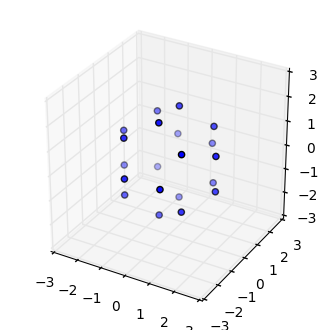

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

x = []
y = []
z = []

with open('CCL_fullerenes/c20.cart3d') as file:
    for line in file:
        if line[2] == 'C': 
            x.append(float(line[11:20])) 
            y.append(float(line[23:32]))
            z.append(float(line[35:44]))  
              
ax.scatter(x,y,z, c='b')
plt.show() 

Note that the points are actually on the surface of a polyhedron, and so these are sometimes referred to as fullerene cage. Only here we do not plots the edges (called bonds), just the data points. The fullerene cage (that is the fullerene with bonds) is shown below.

We compute the bar plot for the above molecule.

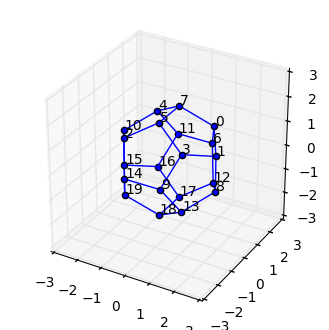

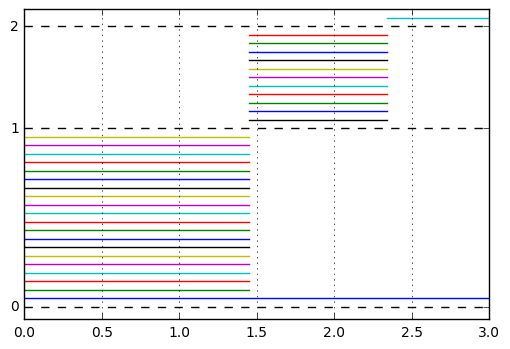

In [7]:
C = np.array([np.hstack(x),np.hstack(y),np.hstack(z)])
V = C.transpose()

#value for the largest epsilon 
eps = 3
k = 4

#plots the complex
PlotVRcomplex(V,VRcomplex(V,k,2)[0])
plt.show()

#computes the corresponding complex
obt_complex = VRcomplex(V,k,eps)
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)

PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()

We compare the obtained bar code with the one provided in the paper

[XFTW] "Persistent Homology for the Quantitative Prediction of Fullerene Stability", by Xia, Feng, Tong, Wei, p.15, (found on ArXiv), to check that the result is correct. 

The Betti number 0 can be interpreted in terms of bond lengths: it tells that the length of the bond is the same between any pairs of atoms. Then when $\epsilon$ reaches close to 1.5, all the atoms get connected and a single connected component is left (which is shown above, it is the fullerene cage).

For the Betti number 1 which is 11 (corresponding to 11 2-dimensional holes), we also notice that all the 11 bars are very regular. So for $\epsilon$ close to $2.5$, all the holes get filled up, and we are left with a single 3-dimensional hole, that is we got a sphere.

Fullerenes got faces which are either pentagons, $n_p$ of them, or hexagons, $n_h$ of them ([XFTW]).
Thus the number $N$ of vertices is given by
$$N = \frac{5n_p+6n_h}{3},$$
and the number of edges is
$$\frac{5n_p+6n_h}{2}$$
while the number of faces is 
$n_p+n_h$.

The Euler characteristic $\chi$ of a $d$-dimensional complex $K$ is defined to be
$$\chi(K)=\sum_{k=0}^d (-1)^k dim C_k$$
where $C_k$ is the group of $k$-chains.
In particular, for the surface of polyhedra in $\mathbb{R}^3$, we have 
$\chi = N - E + F$
where $N$ is the number of vertices, $E$ is the number of edges ($E=(5n_p+6n_h)/2$ for a fullerene) and $F$ is the number of faces ($F=n_p+n_h$ for a fullerene), that is for our case
$$\chi = (5n_p+6n_h)/3 - (5n_p+6n_h)/2 + n_p+n_h,$$ or
$$ 6\chi =  (10n_p-15n_p +6n_p) + (12n_h - 18n_h + 6n_h) = n_p.$$

We remember that the $k$th Betti number $\beta_k$ is the dimension of $H_k$, and 
$$dim H_k = \dim Ker \delta_k - \dim Im \delta_{k+1} = \dim C_k - \dim Im \delta_k - \dim Im \delta_{k+1},$$ 
so we can rewrite $\chi$ as
$$ \chi(K) = \sum_{k=0}^d (-1)^k [\dim Im \delta_k + \dim Im \delta_{k+1} +\beta_k ] = \sum_{k=0}^d (-1)^k \beta_k.$$
The last equality holds because we have a telescopic sum where all the terms cancel each other, and we are left we only $\dim Im\delta_0$ and $\dim Im\delta_{d+1}$, both of them $0$ (all the vertices belong to the kernel of $\delta_0$ and the complex is of dimension $d$). The formula
$$ \chi(K) = \sum_{k=0}^d (-1)^k \beta_k$$
tells us two things.
First, $\chi$ is 2 for the sphere, because the Betti numbers of the sphere are 1,0,1. Now the fullerene cage is topologically a sphere, so
$$6\chi = 12 = n_p$$ and a fullerene has $12$ pentagons. Furthermore, from 
$$N = \frac{5n_p+6n_h}{3} = 20 + n_h,$$
we have
$$
n_h = N/2-10.
$$
For $C_{20}$, $n_h=0$ and we have no hexagonal face.
We understand now that geometrically, these 12 pentagon faces for $C_{20}$ give a second Betti number of 11 (use the 12th face to unfold the cage into a 2-dimensional surface).
Second, for a 1-dimensional complex, we have
$$ N - E = \beta_0 - \beta_1 $$
that is for the fullerene $C_{20}$, $20-5n_p/2 = -10 = \beta_0 - \beta_1 = 1 -\beta_1$, and $\beta_1=11$, which confirm the intuition and bar plot above.

We then repeat the computation with the fullerene $C_{60}$.

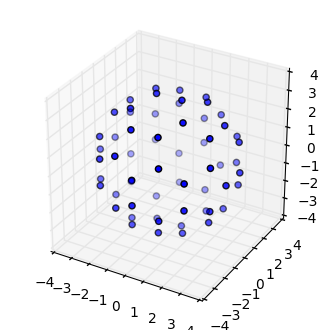

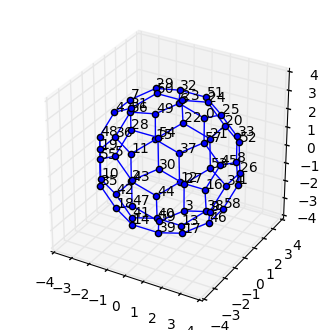

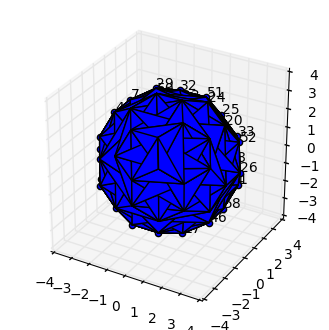

time taken in secs 2.6968367099761963


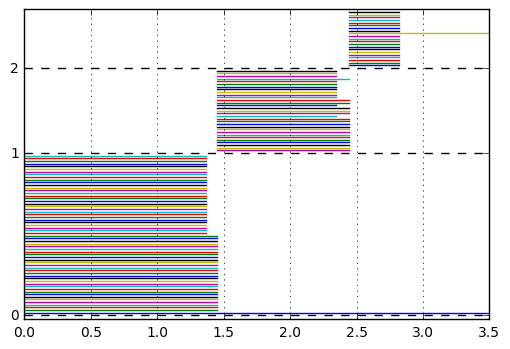

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

x = []
y = []
z = []

with open('CCL_fullerenes/c60.cart3d') as file:
    for line in file:
        if line[2] == 'C': 
            x.append(float(line[11:20])) 
            y.append(float(line[23:32]))
            z.append(float(line[35:44]))  
ax.scatter(x,y,z, c='b')
plt.show() 
            
C = np.array([np.hstack(x),np.hstack(y),np.hstack(z)])
V = C.transpose()


#value for the largest epsilon 
eps = 3.5

#computes the corresponding complex
k = 4
obt_complex = VRcomplex(V,k,eps)

#plots the complex
PlotVRcomplex(V,VRcomplex(V,k,2)[0])
plt.show()
PlotVRcomplex(V,VRcomplex(V,k,eps)[0])
plt.show()

#tic
t = time.time()
#computes its bar codes
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)
#toc 
elapsed = (time.time() - t)
print('time taken in secs',elapsed)

#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()


The bar plot can be checked to be the same as that in the above paper (apart that in the paper, the bar codes are ordered according to their length, while here they are ordered with respect to their appearance).
From the above computations, we know that this fullerene has $n_p=12$ pentagon faces, and $n_h=N/2-10=20$ hexagon faces.
We zoom below into the bars corresponding to the $\beta_1$, and we 31 bars (20+12-1) as expected. We also notice two bond lengths (explained by the fact that we have 2 kinds of faces), 12 short ones and 19 long ones.

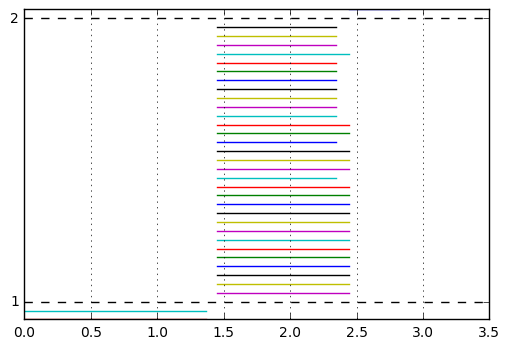

In [14]:
#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.ylim(60, 95)
plt.show()

We then zoom into the bar codes corresponding to $\beta_2$. We have 20 of them, corresponding to the 20 hexagon faces. 
They represent membranes enclosing cavities, so while there is no such phenomeon for $C_{20}$ which has only pentagon faces, for $C_{60}$, we detect hexagonal cavities, but when $\epsilon$ continues to grow, there is one bar that persists, representing a void inside the structure.

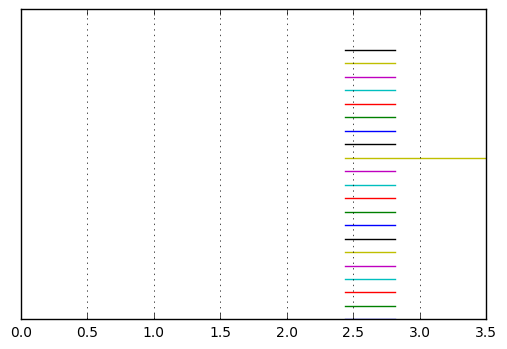

In [18]:
#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.ylim(95, 118)
plt.show()

We now look at another type of data, this time, coming from biology.
Consider the protein PDB ID 1C26 (downloaded from the protein data bank www.rcsb.org).
Following the paper

[XW] "Persistent Homology Analysis of Protein Structure, Flexibility, and Folding", by Xia and Wei, 
(available online), we extract an $\alpha$-helix with 19 residues, represented by 19 atoms. To plot them, we extract the helix information from the pdb file, and then find the corresponding atoms. 

HELIX    1   1 GLY A  334  GLN A  354  1                                  21    



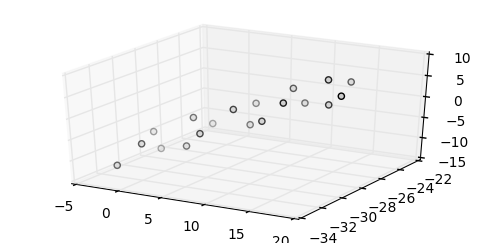

In [26]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

x = []
y = []
z = []
col = []

with open('PDB/1c26.pdb') as pdbfile:
    for line in pdbfile:
        if line[:5] == 'HELIX': 
            print(line)
        if line[:4] == 'ATOM' and line[13:15] == 'CA' and 334 < int(line[23:26]) < 354:
            #print(line) 
            x.append(float(line[32:38])) 
            y.append(float(line[39:46]))
            z.append(float(line[47:54]))  
            col.append(line[77])
        
g_col = [idx for idx in range(0,len(col)) if col[idx]=='C']
r_col = [idx for idx in range(0,len(col)) if col[idx]=='O']
b_col = [idx for idx in range(0,len(col)) if col[idx]=='N']

ax.scatter([x[i] for i in g_col],[y[i] for i in g_col],[z[i] for i in g_col], c='#CCCCCC')
ax.scatter([x[i] for i in r_col],[y[i] for i in r_col],[z[i] for i in r_col], c='r')
ax.scatter([x[i] for i in b_col],[y[i] for i in b_col],[z[i] for i in b_col], c='b')
plt.show() 

We see the atoms have an helix-like shape. We then compute the persistent Betti numbers of this structure.

HELIX    1   1 GLY A  334  GLN A  354  1                                  21    



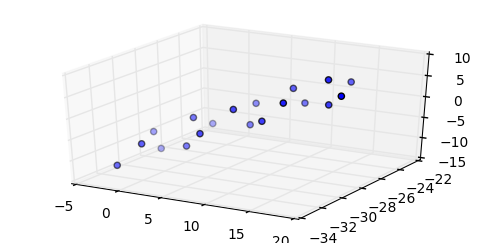

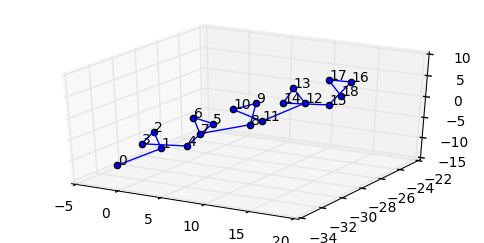

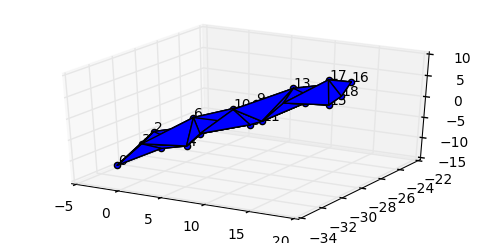

time taken in secs 0.016815662384033203


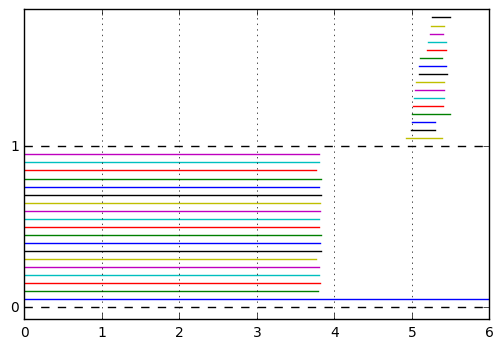

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

x = []
y = []
z = []

with open('PDB/1c26.pdb') as pdbfile:
    for line in pdbfile:
        if line[:5] == 'HELIX': 
            print(line)
        if line[:4] == 'ATOM' and line[13:15] == 'CA' and 334 < int(line[23:26]) < 354:
            x.append(float(line[32:38])) 
            y.append(float(line[39:46]))
            z.append(float(line[47:54]))  
ax.scatter(x,y,z, c='b')
plt.show() 
            
C = np.array([np.hstack(x),np.hstack(y),np.hstack(z)])
V = C.transpose()

#value for the largest epsilon 
eps = 6

#computes the corresponding complex
k = 4
obt_complex = VRcomplex(V,k,eps)

#plots the complex
PlotVRcomplex(V,VRcomplex(V,k,4)[0])
plt.show()
PlotVRcomplex(V,VRcomplex(V,k,eps)[0])
plt.show()

#tic
t = time.time()
#computes its bar codes
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)
#toc 
elapsed = (time.time() - t)
print('time taken in secs',elapsed)

#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()


We find 16 bars for the Betti number $\beta_1$, for 19 atoms. To understand this behavior, following [XW], we take only the first 4 atoms, we compute again the Betti number, and we find $\beta_1=1$.

HELIX    1   1 GLY A  334  GLN A  354  1                                  21    



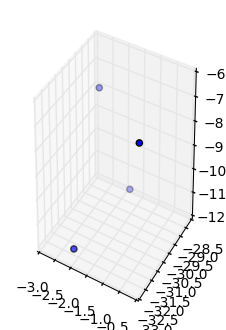

time taken in secs 0.0009086132049560547


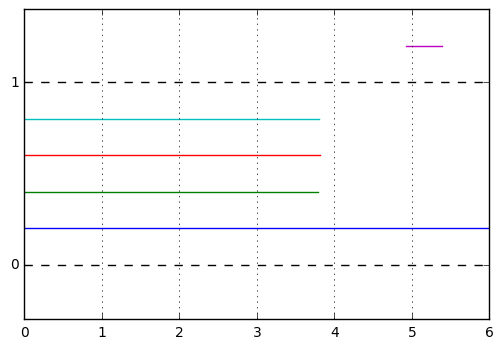

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

x = []
y = []
z = []

with open('PDB/1c26.pdb') as pdbfile:
    for line in pdbfile:
        if line[:5] == 'HELIX': 
            print(line)
        if line[:4] == 'ATOM' and line[13:15] == 'CA' and 334 < int(line[23:26]) < 354:
            x.append(float(line[32:38])) 
            y.append(float(line[39:46]))
            z.append(float(line[47:54]))  
x = x[0:4]
y = y[0:4]
z = z[0:4]
ax.scatter(x,y,z, c='b')
plt.show() 
            
C = np.array([np.hstack(x),np.hstack(y),np.hstack(z)])
V = C.transpose()

#value for the largest epsilon 
eps = 6

#computes the corresponding complex
k = 4
obt_complex = VRcomplex(V,k,eps)

#plots the complex
#PlotVRcomplex(V,VRcomplex(V,k,4)[0])
#plt.show()
#PlotVRcomplex(V,VRcomplex(V,k,eps)[0])
#plt.show()

#tic
t = time.time()
#computes its bar codes
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)
#toc 
elapsed = (time.time() - t)
print('time taken in secs',elapsed)

#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()


We add one atom, and we find that $\beta_1=2$.

HELIX    1   1 GLY A  334  GLN A  354  1                                  21    



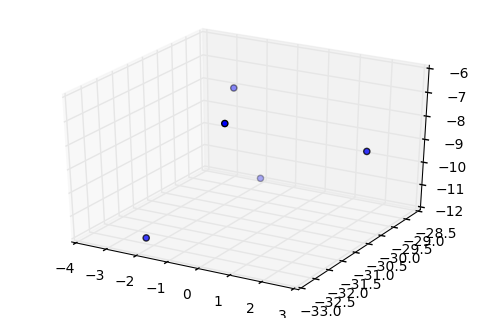

time taken in secs 0.0016283988952636719


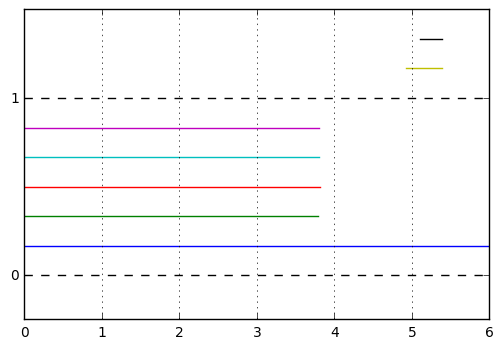

In [32]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

x = []
y = []
z = []

with open('PDB/1c26.pdb') as pdbfile:
    for line in pdbfile:
        if line[:5] == 'HELIX': 
            print(line)
        if line[:4] == 'ATOM' and line[13:15] == 'CA' and 334 < int(line[23:26]) < 354:
            x.append(float(line[32:38])) 
            y.append(float(line[39:46]))
            z.append(float(line[47:54]))  
x = x[0:5]
y = y[0:5]
z = z[0:5]
ax.scatter(x,y,z, c='b')
plt.show() 
            
C = np.array([np.hstack(x),np.hstack(y),np.hstack(z)])
V = C.transpose()

#value for the largest epsilon 
eps = 6

#computes the corresponding complex
k = 4
obt_complex = VRcomplex(V,k,eps)

#plots the complex
#PlotVRcomplex(V,VRcomplex(V,k,4)[0])
#plt.show()
#PlotVRcomplex(V,VRcomplex(V,k,eps)[0])
#plt.show()

#tic
t = time.time()
#computes its bar codes
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)
#toc 
elapsed = (time.time() - t)
print('time taken in secs',elapsed)

#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()


We add one more atom, and we find that $\beta_1=3$.

HELIX    1   1 GLY A  334  GLN A  354  1                                  21    



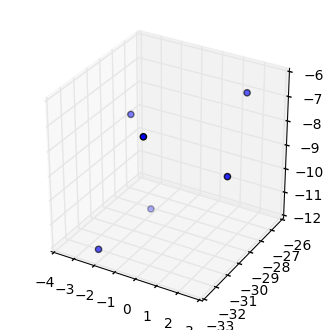

time taken in secs 0.0017821788787841797


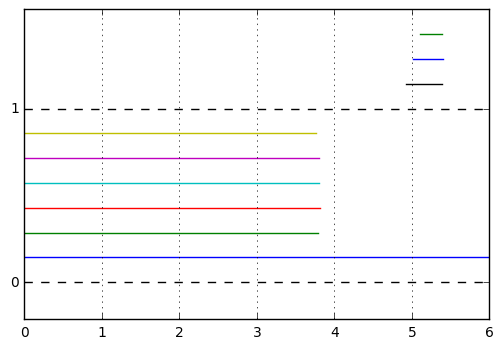

In [33]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

x = []
y = []
z = []

with open('PDB/1c26.pdb') as pdbfile:
    for line in pdbfile:
        if line[:5] == 'HELIX': 
            print(line)
        if line[:4] == 'ATOM' and line[13:15] == 'CA' and 334 < int(line[23:26]) < 354:
            x.append(float(line[32:38])) 
            y.append(float(line[39:46]))
            z.append(float(line[47:54]))  
x = x[0:6]
y = y[0:6]
z = z[0:6]
ax.scatter(x,y,z, c='b')
plt.show() 
            
C = np.array([np.hstack(x),np.hstack(y),np.hstack(z)])
V = C.transpose()

#value for the largest epsilon 
eps = 6

#computes the corresponding complex
k = 4
obt_complex = VRcomplex(V,k,eps)

#plots the complex
#PlotVRcomplex(V,VRcomplex(V,k,4)[0])
#plt.show()
#PlotVRcomplex(V,VRcomplex(V,k,eps)[0])
#plt.show()

#tic
t = time.time()
#computes its bar codes
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)
#toc 
elapsed = (time.time() - t)
print('time taken in secs',elapsed)

#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()


This explains the 16 bars: when we have 4 atoms, we get one bar, corresponding to one cycle (1-dimensional loop). When we add one atom, the first 4 atoms (atoms 1 to 4) still give a loop, and the last 4 atoms (atoms 2 to 5) give another loop.
With 6 atoms, atoms 1-4, 2-5, 3-6 give 3 loops, so when we have the 19 atoms, we get 16 loops.